In [1]:
!pip install -q pyomo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.7 MB/s eta 0:00:00


In [2]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pyomo.opt import SolverStatus, TerminationCondition

## Pricing w/o Fairness

In [63]:
from pyomo.environ import *

def pricing(Lambda1, Lambda2, b1, b2, m = 1, Debug = True):
  C = [i for i in range(0,m+1)] # # of Cars in 2

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi = Var(C, domain = NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c = ConstraintList()
  model.c.add(model.l1 <= Lambda1)
  model.c.add(model.l2 <= Lambda2)
  model.c.add(sum([model.pi[i] for i in range(m+1)]) == 1)
  for i in range(0,m):
    model.c.add(model.pi[i] * model.l1 == model.pi[i+1] * model.l2)

  # Revenue
  model.revenue = Objective(expr = model.l1 * (1-model.pi[m]) * model.p1 +\
                           model.l2 * (1-model.pi[0]) * model.p2, sense=maximize)

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('(p1, p2) = (%.3f, %.3f)' %(model.p1(), model.p2()))
    print('(l1, l2) = (%.3f, %.3f)' %(model.l1(), model.l2()))
    for i in range(m+1):
      print('steady_state %d%d = %.3f' %(m-i,i,model.pi[i]()))

    l1, l2 = model.l1(), model.l2()
    beta1 = b1/Lambda1
    beta2 = b2/Lambda2
    welfare_sign = (2 * l1 * l2 *(pow(l2,m)-pow(l1,m)) - m * (l2 - l1) * (pow(l2,m+1)+pow(l1,m+1))) * (l1/beta2 - l2/beta1) / (l2 - l1)
    welfare_checker = (welfare_sign >= 0)
    print('welfare >= 0 (under price fairness)?', welfare_checker)

  M1 = model.p1() - model.p2()
  M2 = model.l1()/Lambda1 * (1-model.pi[m]()) - model.l2()/Lambda2 * (1-model.pi[0]())

  return {'Price': abs(M1), 'Access': abs(M2)}

## Pricing w/ Fair Constraints

In [64]:
from pyomo.environ import *

def fair_pricing(Lambda1, Lambda2, b1, b2, m, M_star, alpha, criteria = 'Price', Debug = False):

  C = [i for i in range(0,m+1)] # # of Cars in 2

  # create a model
  model = ConcreteModel()

  # declare decision variables
  model.l1 = Var(domain=NonNegativeReals)
  model.l2 = Var(domain=NonNegativeReals)
  model.pi = Var(C, domain = NonNegativeReals)

  # price
  model.p1 = b1 * (1-model.l1/Lambda1)
  model.p2 = b2 * (1-model.l2/Lambda2)

  # Constraints
  model.c = ConstraintList()
  model.c.add(model.l1 <= Lambda1)
  model.c.add(model.l2 <= Lambda2)
  model.c.add(sum([model.pi[i] for i in range(m+1)]) == 1)
  for i in range(0,m):
    model.c.add(model.pi[i] * model.l1 == model.pi[i+1] * model.l2)

  # Revenue
  model.revenue = Objective(expr = model.l1 * (1-model.pi[m]) * model.p1 +\
                           model.l2 * (1-model.pi[0]) * model.p2, sense=maximize)
  M_star = M_star[criteria]

  if criteria == 'Price':
    model.c.add(model.p1 - model.p2 <= (1-alpha) * M_star)
    model.c.add(model.p2 - model.p1 <= (1-alpha) * M_star)
  elif criteria == 'Access':
    model.c.add(model.l1/Lambda1 * (1-model.pi[m]) - model.l2/Lambda2 * (1-model.pi[0]) <= (1-alpha) * M_star)
    model.c.add(model.l2/Lambda2 * (1-model.pi[0]) - model.l1/Lambda1 * (1-model.pi[m]) <= (1-alpha) * M_star)
  else:
    print("Warning: no criteria matached")

  SolverFactory('couenne').solve(model)#.write()

  # display solution
  if Debug:
    print('\nRevenue = ', model.revenue())

    print('Optimal Variables')
    print('p1 =', model.p1())
    print('p2 =', model.p2())
    print('l1= ', model.l1())
    print('l2= ', model.l2())
    for i in range(m+1):
      print('steady_state %d%d = %.3f' %(m-i,i,model.pi[i]()))

  S1 = pow(b1-model.p1(),2)/(2*b1) * (1-model.pi[m]())
  S2 = pow(b2-model.p2(),2)/(2*b2) * (1-model.pi[0]())
  total_surplus = Lambda1 * S1 + Lambda2 * S2

  steady_state = [model.pi[i]() for i in range(m+1)]

  return [model.p1(), model.p2()], model.revenue(), [S1, S2], total_surplus, [model.l1()/Lambda1 * (1-model.pi[m]()), model.l2()/Lambda2 * (1-model.pi[0]())], steady_state

## Plots

In [65]:
def simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=['Price', 'Access'], n_iter=10, Debug=False):
  M_star = pricing(Lambda1, Lambda2, b1, b2, m, Debug=Debug)

  price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = {}, {}, {}, {}, {}, {}
  for criteria in criteria_list:
    print("Criteria %s start" %(criteria))
    price_list, revenue_list, surplus_list, total_surplus_list, lambda_list = [], [], [], [], []
    pi_list = [[] for i in range(m+1)]
    for a in range(n_iter+1):
      price, revenue, surplus, total_surplus, _lambda, steady_state = fair_pricing(Lambda1, Lambda2, b1, b2, m, M_star, a/n_iter, criteria = criteria, Debug=Debug)
      price_list.append(price)
      revenue_list.append(revenue)
      surplus_list.append(surplus)
      total_surplus_list.append(total_surplus)
      lambda_list.append(_lambda)
      for j in range(len(steady_state)):
        pi_list[j].append(steady_state[j])

    price_all[criteria] = price_list
    revenue_all[criteria] = revenue_list
    surplus_all[criteria] = surplus_list
    total_surplus_all[criteria] = total_surplus_list
    lambda_all[criteria] = lambda_list
    pi_all[criteria] = pi_list

  return price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all

In [66]:
def subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all):
  price_list, revenue_list, surplus_list, total_surplus_list, access_list, pi_list\
   = price_all[criteria], revenue_all[criteria], surplus_all[criteria], total_surplus_all[criteria], access_all[criteria], pi_all[criteria]

  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 28
  n_iter = len(revenue_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)]

  axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
  axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)
  #axs[0].set_title(criteria + " Fairness", fontsize=size)
  axs[0].set_xlim([0, 1])
  axs[0].grid()

  axs[1].plot(iter_list, [p[0] for p in price_list], label=r'$p_1$',linewidth=3.0)
  axs[1].plot(iter_list, [p[1] for p in price_list], label=r'$p_2$',linewidth=3.0)
  #axs[1].set_title("Price", fontsize=size)
  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].plot(iter_list, [s[0] for s in access_list], label=r'$A_1$',linewidth=3.0)#\Pi_1q_1
  axs[2].plot(iter_list, [s[1] for s in access_list], label=r'$A_2$',linewidth=3.0)
  #axs[2].set_title("(Normalized) Surplus", fontsize=size)
  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].plot(iter_list, [s[0] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0)
  axs[3].plot(iter_list, [s[1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0)
  axs[3].set_xlim([0, 1])
  axs[3].grid()


  for i in range(4):
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.3),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.show()

In [67]:
def subplot_overlapping(criteria, price_all, revenue_all, surplus_all, total_surplus_all, access_all, pi_all):

  fig, axs = plt.subplots(1, 4)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  size = 28

  for i in range(len(price_whole)):

    price_list, revenue_list, surplus_list, total_surplus_list, access_list, pi_list\
      = price_all[i][criteria], revenue_all[i][criteria], surplus_all[i][criteria], total_surplus_all[i][criteria], access_all[i][criteria], pi_all[i][criteria]

    n_iter = len(revenue_list)
    iter_list = [i/(n_iter-1) for i in range(n_iter)]

    if i == 0:
      alpha = 0.7

      axs[0].plot(iter_list, revenue_list, color='r', linewidth=2.0, alpha=alpha, linestyle='dashed')
      axs[0].plot(iter_list, total_surplus_list, color='g', linewidth=2.0, alpha=alpha, linestyle='dashed')
      axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', linewidth=2.0, alpha=alpha, linestyle='dashed')

      axs[1].plot(iter_list, [p[0] for p in price_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[1].plot(iter_list, [p[1] for p in price_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

      axs[2].plot(iter_list, [s[0] for s in access_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[2].plot(iter_list, [s[1] for s in access_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

      axs[3].plot(iter_list, [s[0] for s in surplus_list],linewidth=2.0, alpha=alpha, color='C0', linestyle='dashed')
      axs[3].plot(iter_list, [s[1] for s in surplus_list],linewidth=2.0, alpha=alpha, color='C1', linestyle='dashed')

    else:
      axs[0].plot(iter_list, revenue_list, color='r', label = r'$\mathcal{R}(\alpha)$', linewidth=3.0)
      axs[0].plot(iter_list, total_surplus_list, color='g', label = r'$\mathcal{S}(\alpha)$', linewidth=3.0)
      axs[0].plot(iter_list, [revenue_list[i] + total_surplus_list[i] for i in range(n_iter)], color='b', label = r'$\mathcal{W}(\alpha)$', linewidth=3.0)

      axs[1].plot(iter_list, [p[0] for p in price_list], label=r'$p_1$',linewidth=3.0, color='C0')
      axs[1].plot(iter_list, [p[1] for p in price_list], label=r'$p_2$',linewidth=3.0, color='C1')

      axs[2].plot(iter_list, [s[0] for s in access_list], label=r'$A_1$',linewidth=3.0, color='C0')
      axs[2].plot(iter_list, [s[1] for s in access_list], label=r'$A_2$',linewidth=3.0, color='C1')

      axs[3].plot(iter_list, [s[0] for s in surplus_list], label=r'$\mathcal{S}_1$',linewidth=3.0, color='C0')
      axs[3].plot(iter_list, [s[1] for s in surplus_list], label=r'$\mathcal{S}_2$',linewidth=3.0, color='C1')


  axs[0].set_xlim([0, 1])
  axs[0].grid()

  axs[1].set_xlim([0, 1])
  axs[1].grid()

  axs[2].set_xlim([0, 1])
  axs[2].grid()

  axs[3].set_xlim([0, 1])
  axs[3].grid()

  for i in range(4):
    # Put a legend below current axis
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25),
                  fancybox=True, shadow=True, ncol=3, prop={"size":18})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28)

  plt.show()

## Experiments

### Price Fairness

In [68]:
criteria_list = ['Price']

In [69]:
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole= [],[],[],[],[],[]

Criteria Price start


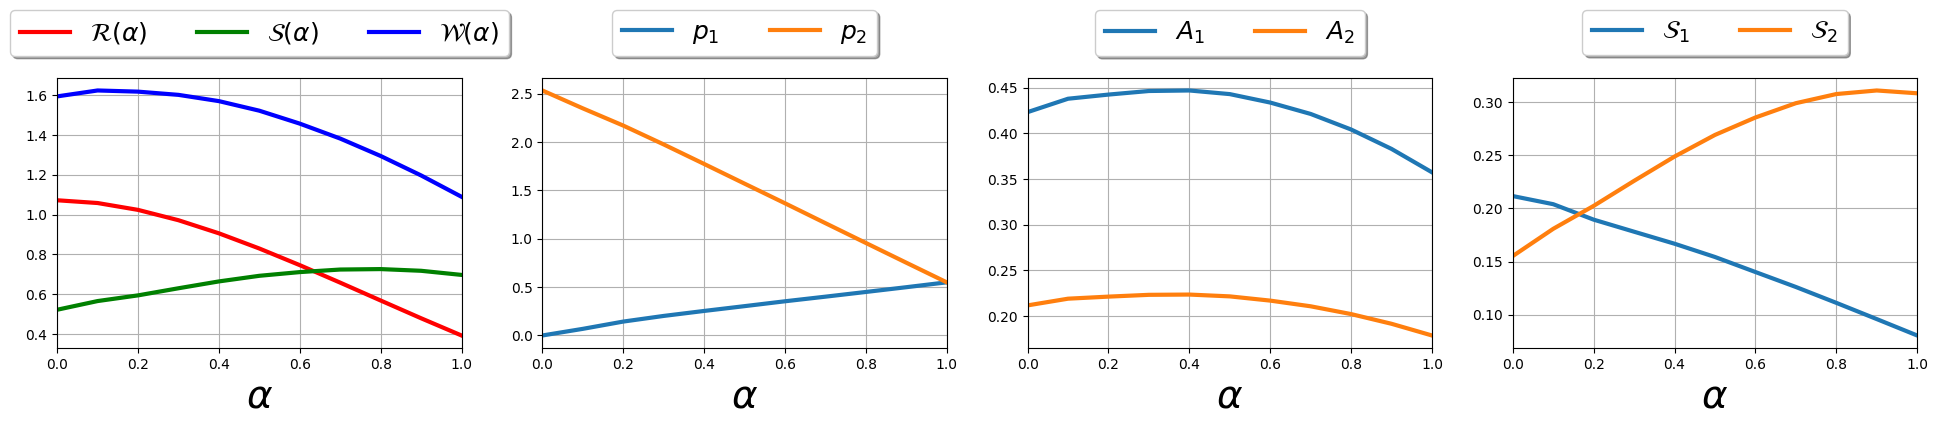

In [70]:
Lambda1, Lambda2 = 1, 2
b1, b2 = 1, 4
m = 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

Criteria Price start


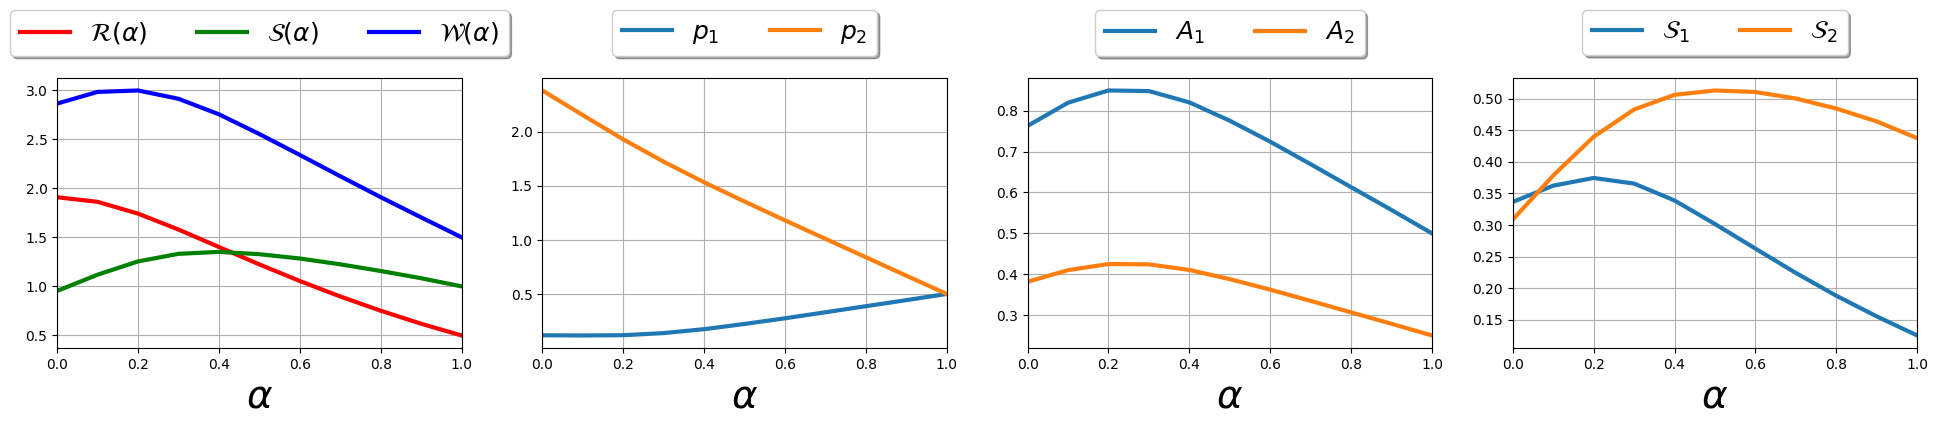

In [71]:
Lambda1, Lambda2 = 1, 2
b1, b2 = 1, 4
m = 10
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

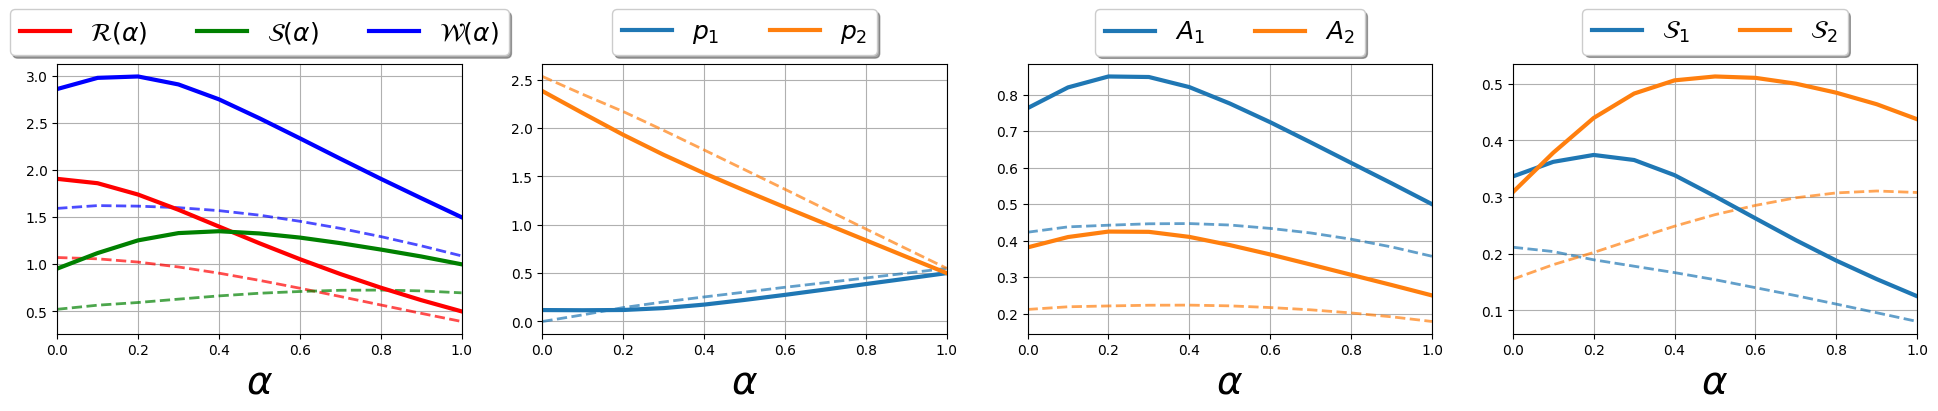

In [72]:
subplot_overlapping(criteria, price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole)

### Access Fairness

In [73]:
criteria_list = ['Access']

In [74]:
#1
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole= [],[],[],[],[],[]

Criteria Access start


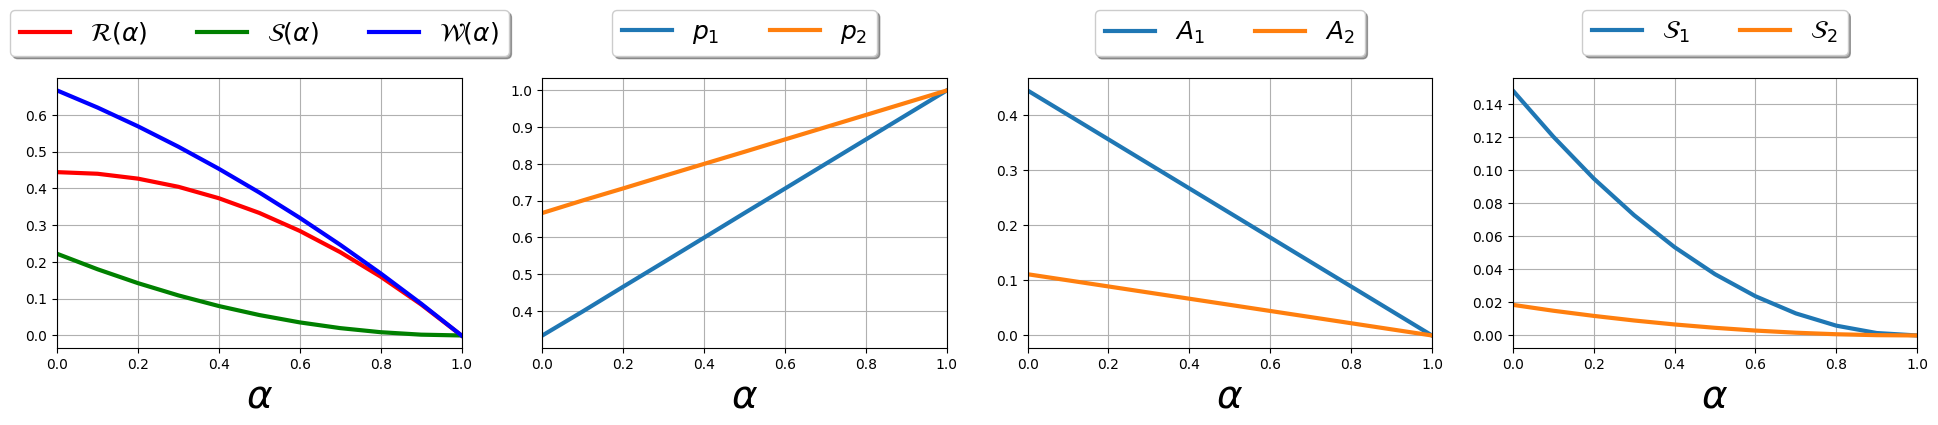

In [75]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 1
m = 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

Criteria Access start


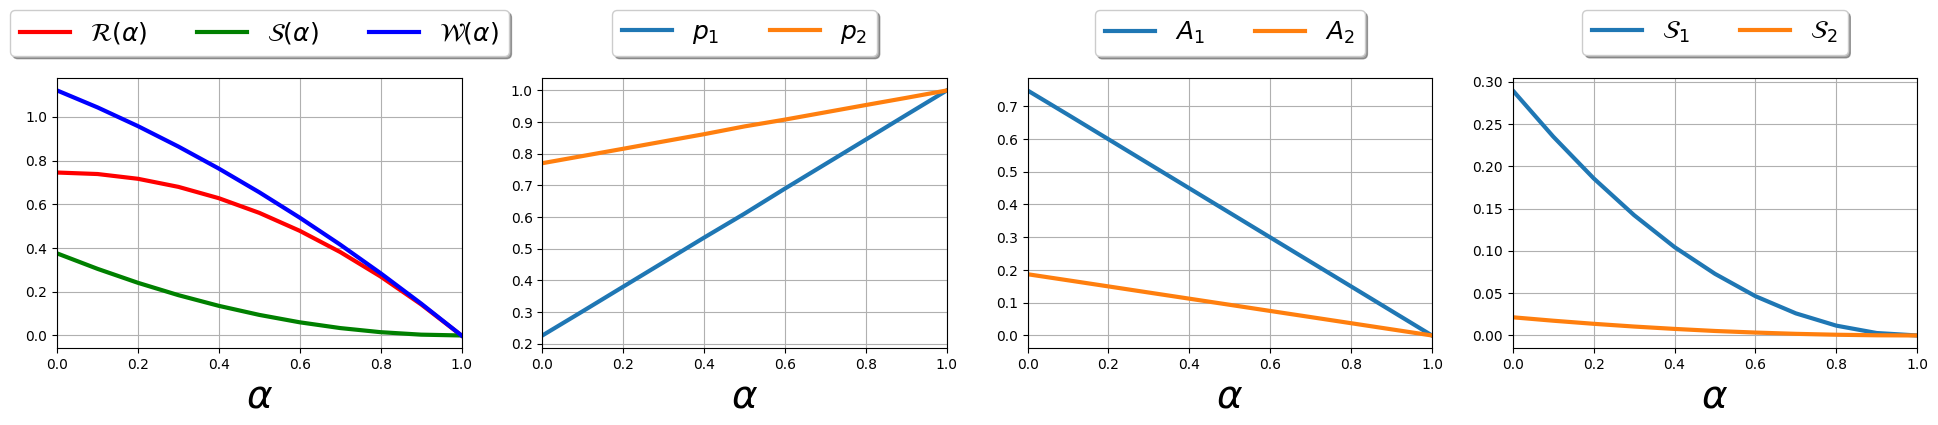

In [76]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 1
m = 10
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

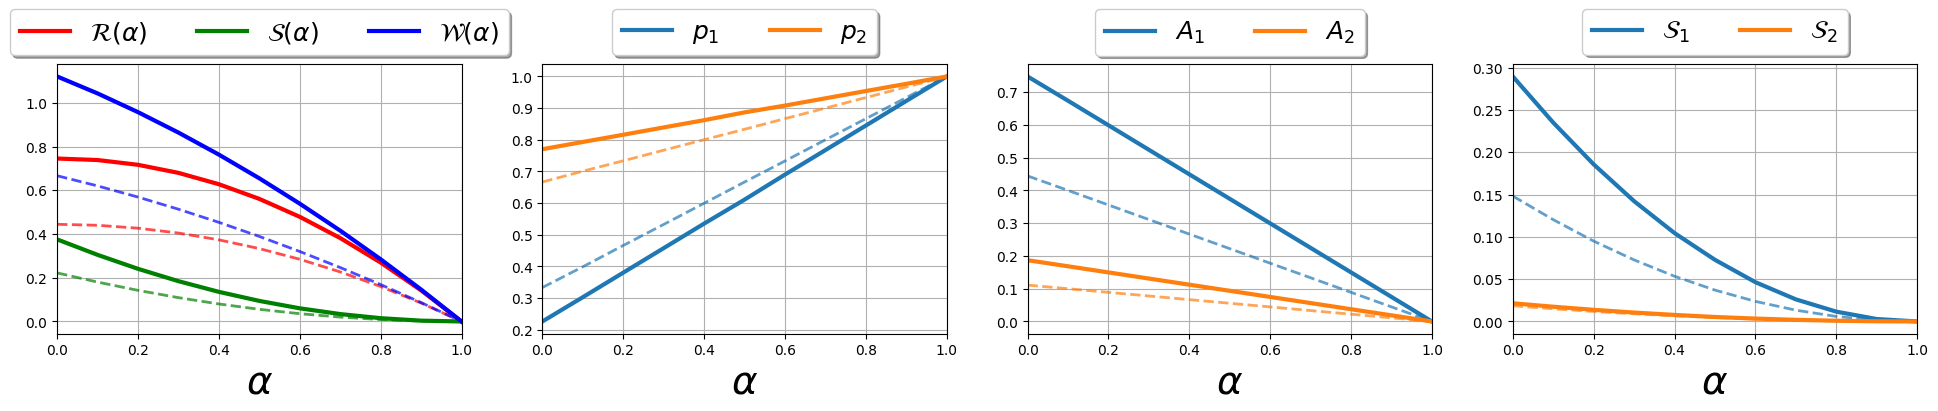

In [77]:
subplot_overlapping(criteria, price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole)

In [78]:
#2
price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole= [],[],[],[],[],[]

Criteria Access start


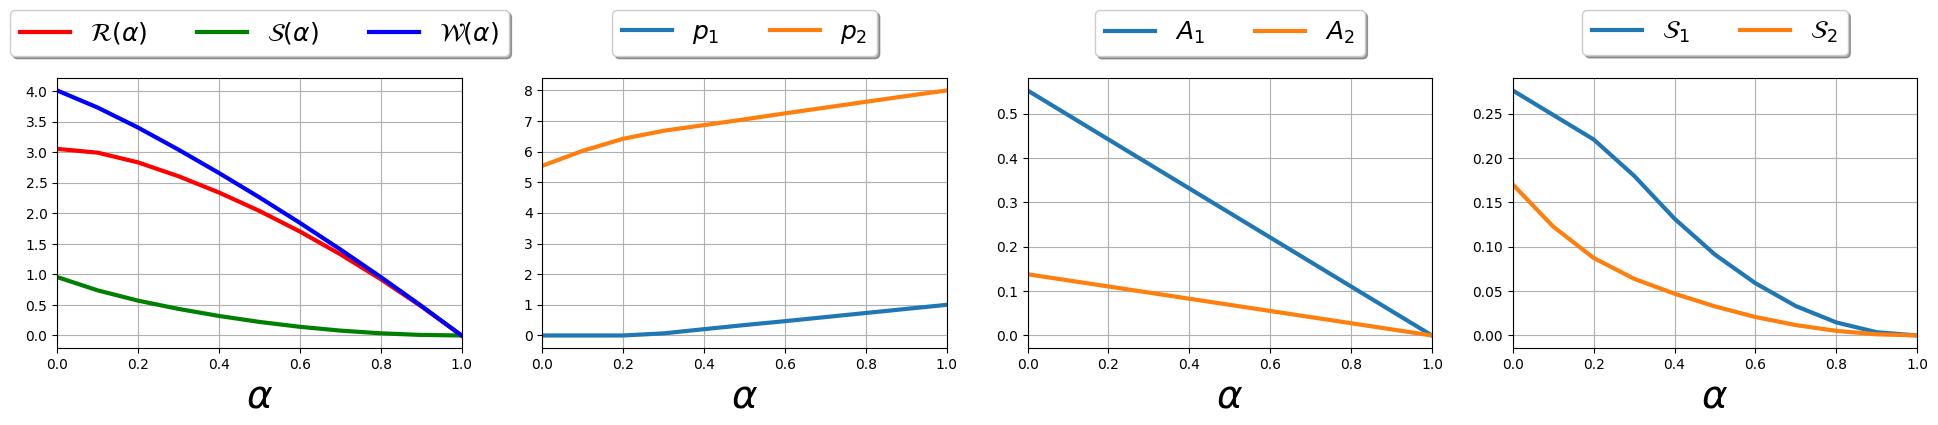

In [79]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 8
m = 1
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

Criteria Access start


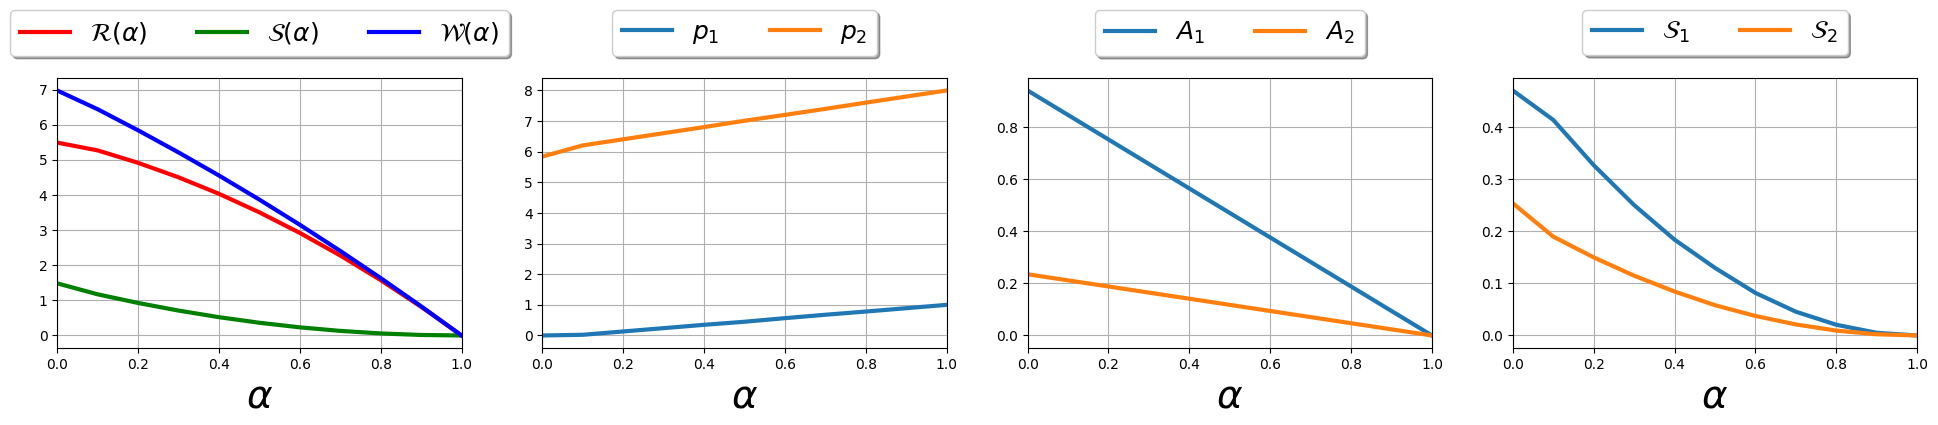

In [80]:
Lambda1, Lambda2 = 1, 4
b1, b2 = 1, 8
m = 10
price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all = simulator(Lambda1, Lambda2, b1, b2, m, criteria_list=criteria_list, Debug=False)

for criteria in criteria_list:
  subplot_drawing(criteria, price_all, revenue_all, surplus_all, total_surplus_all, lambda_all, pi_all)

price_whole.append(price_all)
revenue_whole.append(revenue_all)
surplus_whole.append(surplus_all)
total_surplus_whole.append(total_surplus_all)
access_whole.append(lambda_all)
pi_whole.append(pi_all)

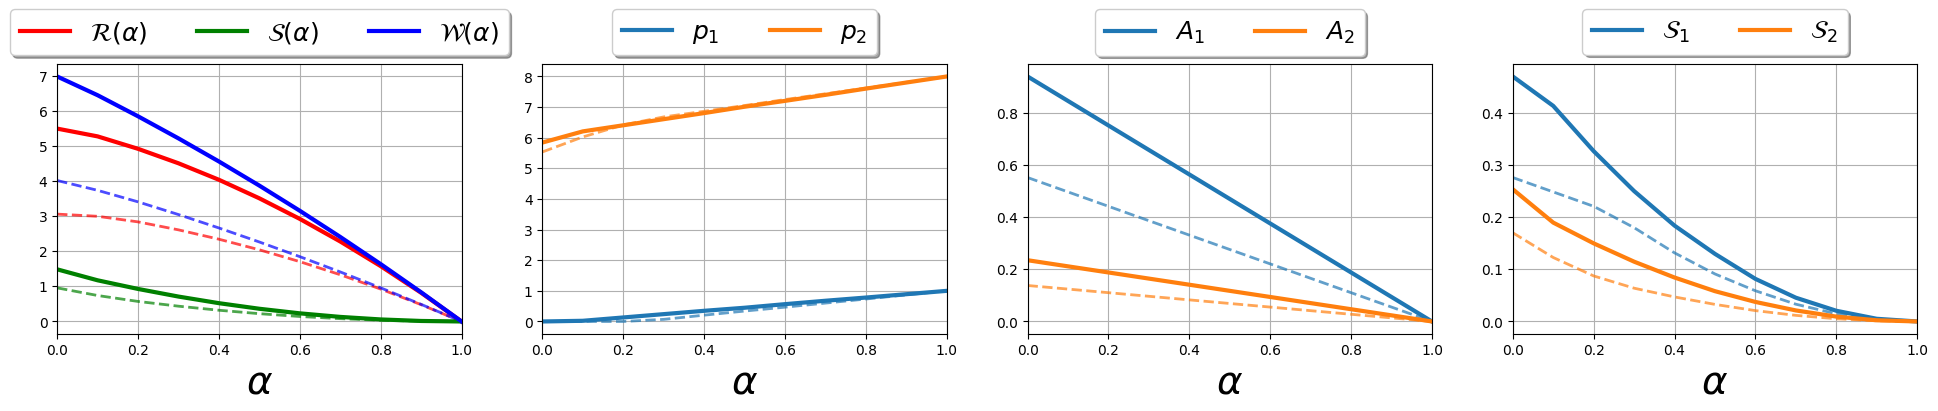

In [81]:
subplot_overlapping(criteria, price_whole, revenue_whole, surplus_whole, total_surplus_whole, access_whole, pi_whole)